## Wine Classification

### O problema
O presente problema se refere aos dados de vinhos portugueses "Vinho Verde", que possuem
variantes de vinho branco e tinto. Devido a questões de privacidade, apenas variáveis
físico-químicas (input) e sensoriais (output) estão disponíveis (por exemplo, não há dados
sobre tipo de uva, marca do vinho, preço de venda, etc).

### Objetivo
Criar um modelo para estimar a qualidade do vinho.
Informação sobre os atributos
Variáveis input (baseado em testes físico-químicos):
1. Tipo
2. Acidez fixa
3. Volatilidade da acidez
4. Ácido cítrico
5. Açúcar residual
6. Cloretos
7. Dióxido de enxofre livre
8. Dióxido de enxofre total
9. Densidade
10. pH
11. Sulfatos
12. Álcool
Variável output (baseado em dado sensorial):
13. Qualidade (score entre 0 and 10)

In [1]:
#Importando as bibliotecas necessárias
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#Realizando o load do arquivo de dados
df = pd.read_csv('./data/input/winequality.csv', delimiter=';', header=0)

### Análise exploratória do dataset

Iremos agora verificar o dataset, afim de verificar os dados e a qualidade dos mesmos, assim como a correlação destes com a variável target (quality).

In [3]:
#Visualização inicial dos dados
df.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,White,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,White,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11,6


In [4]:
#Verificando tipos de dados
df.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

In [5]:
#ERRO ESPERADO NESTA CÉLULA
#Alcohol deveria ser float, tentando cast, mas dá erro
df.alcohol.astype(np.float64)

ValueError: could not convert string to float: '923.333.333.333.333'

In [6]:
#Coluna possui dados inválidos, identificando os mesmos
for item in df['alcohol']:
    if len(item) > 7:
        print(item)

128.933.333.333.333
128.933.333.333.333
114.666.666.666.667
100.333.333.333.333
114.333.333.333.333
105.333.333.333.333
953.333.333.333.333
109.333.333.333.333
109.333.333.333.333
113.666.666.666.667
113.333.333.333.333
110.666.666.666.667
113.333.333.333.333
973.333.333.333.333
973.333.333.333.333
113.333.333.333.333
123.333.333.333.333
112.666.666.666.667
105.666.666.666.667
117.333.333.333.333
109.666.666.666.667
109.666.666.666.667
109.666.666.666.667
101.333.333.333.333
101.333.333.333.333
104.666.666.666.667
104.666.666.666.667
116.333.333.333.333
116.333.333.333.333
131.333.333.333.333
120.666.666.666.667
963.333.333.333.333
953.333.333.333.333
953.333.333.333.333
100.333.333.333.333
100.333.333.333.333
110.666.666.666.667
956.666.666.666.667
135.666.666.666.667
923.333.333.333.333


In [7]:
#Verificando tamanho do dataset antes de alterar o mesmo
df.shape

(6497, 13)

In [8]:
#Removendo registros com alcohol corrompido
i = 0
indexList = list()
for item in df['alcohol']:
    if len(item) > 7:
        indexList.append(i)
    i = i + 1

df.drop(df.index[indexList], inplace=True)        
df.shape

(6457, 13)

In [9]:
#Verificando se coluna ainda possui dados inválidos, identificando os mesmos
for item in df['alcohol']:
    if len(item) > 7:
        print(item)

In [10]:
#Alcohol deveria ser float, tentando cast
df['alcohol'] = df.alcohol.astype(np.float64)
df.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [11]:
#Verificação estatística e de distribuição dos dados
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000
mean,7.219475,0.339684,0.318795,5.445973,0.056081,30.495586,115.690801,1.715329,3.218592,0.531169,10.489083,5.817098
std,1.294910,0.164690,0.145506,4.764308,0.035110,17.757007,56.595196,7.659497,0.160845,0.148870,1.192961,0.874125
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992350,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,14.900000,9.000000


In [12]:
#Verificando a existência de dados duplicados
dfDuplicado = pd.DataFrame.duplicated(df,keep='first')
df[dfDuplicado].shape

(1169, 13)

In [13]:
#Verificando a contagem de registros dos atributos por variável target (quality)
df.groupby('quality').count()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,,
3,30,30,30,30,30,30,30,30,30,30,30,30
4,216,216,216,216,216,216,216,216,216,216,216,216
5,2129,2129,2129,2129,2129,2129,2129,2129,2129,2129,2129,2129
6,2815,2815,2815,2815,2815,2815,2815,2815,2815,2815,2815,2815
7,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069,1069
8,193,193,193,193,193,193,193,193,193,193,193,193
9,5,5,5,5,5,5,5,5,5,5,5,5


In [14]:
#Verificando a contagem de registros dos atributos por tipo de vinho
df.groupby('type').count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
type,,,,,,,,,,,,
Red,1593,1593,1593,1593,1593,1593,1593,1593,1593,1593,1593,1593
White,4864,4864,4864,4864,4864,4864,4864,4864,4864,4864,4864,4864


In [15]:
#Verificando a presença de valores nulos no dataset
df.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

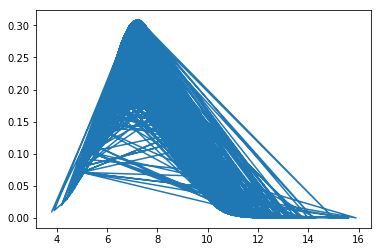

In [16]:
#Distribuição gráfica de feature com baixo desvio padrão
plt.plot(df['fixed acidity'], norm.pdf(df['fixed acidity'],df['fixed acidity'].mean(),df['fixed acidity'].std()))
plt.show()

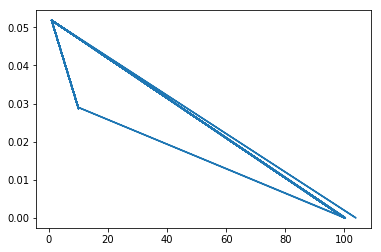

In [17]:
#Distribuição gráfica de feature com alto desvio padrão
plt.plot(df['density'], norm.pdf(df['density'],df['density'].mean(),df['density'].std()))
plt.show()

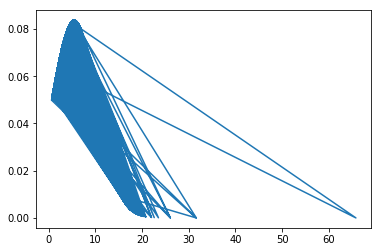

In [18]:
#Distribuição gráfica de feature com alto desvio padrão
plt.plot(df['residual sugar'], norm.pdf(df['residual sugar'],df['residual sugar'].mean(),df['residual sugar'].std()))
plt.show()

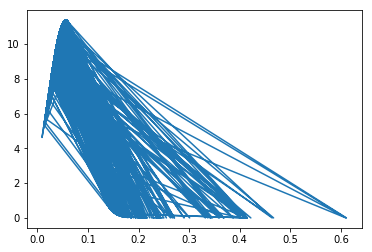

In [19]:
#Distribuição gráfica de feature com alto desvio padrão
plt.plot(df['chlorides'], norm.pdf(df['chlorides'],df['chlorides'].mean(),df['chlorides'].std()))
plt.show()

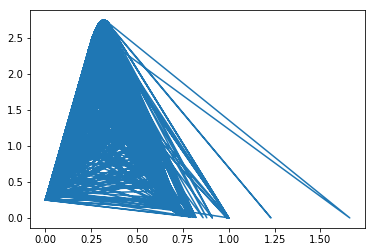

In [20]:
#Distribuição gráfica de feature com alto desvio padrão
plt.plot(df['citric acid'], norm.pdf(df['citric acid'],df['citric acid'].mean(),df['citric acid'].std()))
plt.show()

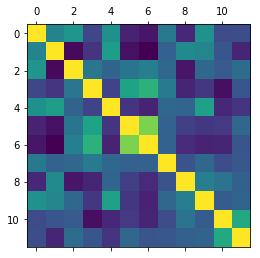

In [21]:
#Verificando a matriz de correlação das features
plt.matshow(df.corr())

In [22]:
#Vendo os dados da matriz de correlação
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,0.218711,0.324815,-0.112389,0.297079,-0.281115,-0.328131,0.159592,-0.251962,0.301531,-0.093692,-0.076899
volatile acidity,0.218711,1.000000,-0.378046,-0.196240,0.376801,-0.353040,-0.415214,0.030943,0.261400,0.226266,-0.036916,-0.267041
citric acid,0.324815,-0.378046,1.000000,0.141384,0.038676,0.133508,0.195571,0.057749,-0.329248,0.056272,-0.009087,0.085573
residual sugar,-0.112389,-0.196240,0.141384,1.000000,-0.129404,0.403418,0.495998,0.175994,-0.266895,-0.185948,-0.359799,-0.037997
chlorides,0.297079,0.376801,0.038676,-0.129404,1.000000,-0.194374,-0.279826,0.061558,0.045037,0.396991,-0.255883,-0.200425
free sulfur dioxide,-0.281115,-0.353040,0.133508,0.403418,-0.194374,1.000000,0.720979,0.029878,-0.146405,-0.188002,-0.180348,0.055472
total sulfur dioxide,-0.328131,-0.415214,0.195571,0.495998,-0.279826,0.720979,1.000000,0.031136,-0.239278,-0.275119,-0.266148,-0.040801
density,0.159592,0.030943,0.057749,0.175994,0.061558,0.029878,0.031136,1.000000,-0.052909,0.063041,-0.080264,-0.029424
pH,-0.251962,0.261400,-0.329248,-0.266895,0.045037,-0.146405,-0.239278,-0.052909,1.000000,0.191299,0.121955,0.020345
sulphates,0.301531,0.226266,0.056272,-0.185948,0.396991,-0.188002,-0.275119,0.063041,0.191299,1.000000,-0.004484,0.037495


### Análise dos dados

Podemos verificar que o dataset possui 12 features que poderão ser responsáveis por predizer a variável target (Quality), somando assim 13 colunas no total.

O dataset possui features com uma distribuição de dados variada. Algumas features possuem uma distribuição que parece se assemelhar com uma curva normal, enquanto outras features possuem dados muito espaçados, o que pode afetar o algoritmo de classificação. Este assunto precisa ser tratado, para verificar se o descarte de dados será necessário.

O dataset possui 6.497 registros, nenhum valor nulo e 1.177 registros duplicados (18% do dataset, já desconsiderando a primeira ocorrência dos duplicados). Dada a natureza sigilosa do dataset, é tecnicamente possível que os dados sejam iguais mas que se refiram a vinhos diferentes. De qualquer forma, este assunto será tratado posteriormente.

O problema é de classificação multi-classes, visto que a feature Quality não é um valor contínuo (o que qualificaria o problema como regressão, caso fossem valores contínuos). As classes estão desbalanceadas, com muitos vinhos médios e poucos vinhos ruins e bons, o que reflete a realidade dos vinhos no mundo real, e deve ser endereçado na modelagem também.

As features que possuem maior correlação positiva com o target são "alcohol" e "citric acid". As features com maior correlação negativa são: "volatile acidity" e "chlorides".

### Modelagem dos dados

Iremos trabalhar com 4 dataframes para a modelagem. Estes dataframes irão se diferenciar pela quantidade de features (1. todas / 2. apenas as de maior correlação) e também pela presença (ou não) de dados duplicados.

As classes serão balanceadas entre si para a criação do modelo. Testaremos balanceamento com criação de valores sintéticos através de SMOTE.

No final, teremos os seguintes modelos sendo testados:

    Modelo 1: Todas as features / Com dados duplicados / Com criação de dados sintéticos para balanceamento

    Modelo 2: Todas as features / Sem dados duplicados / Com criação de dados sintéticos para balanceamento

    Modelo 3: Apenas features correlatas / Com dados duplicados / Com criação de dados sintéticos para balanceamento

    Modelo 4: Apenas features correlatas / Sem dados duplicados / Com criação de dados sintéticos para balanceamento
    

### Avaliação do modelo

Por se tratar de um problema de classificação multi-classes, utilizaremos a acurácia balanceada para validar os modelos entre si.

## Criação dos modelos

In [23]:
#Criação dos dataframes para os modelos
df['type'] = df.type.map({'Red': 1, 'White': 0})

dfModelo01 = df

dfModelo02 = df.drop_duplicates(keep='first', inplace=False)

corrColumns = ['alcohol','citric acid', 'volatile acidity', 'chlorides','quality']
dfModelo03 = df[corrColumns]

dfModelo04 = df[corrColumns].drop_duplicates(keep='first', inplace=False)

In [24]:
#Função para display de resultados
def appendResult(alg, dataframe, fase, X, y):
    algName = type(alg).__name__
    predicted = alg.predict(X)
    accuracy = accuracy_score(y, predicted)
    results.loc[len(results)]=[algName, dataframe, fase, accuracy]

In [34]:
#Função para dividir o dataset em 3 partes
def train_val_test_split(X, y, test_size=0.2, random_state=0, over_sampling=False):
    """Gets input data and returns it splitted in three parts (training, validation and testing). Optionally, it can oversample the data.
    
    Parameters:
    -----------
    X: `pandas.DataFrame` or `pandas.Series`. Contains model features.
    y: `pandas.Series`. Contains the model target.
    test_size: `float`. test_size will be passed to sklearn.model_selection.train_test_split function.
    random_state: `integer`. random_state will be passed to sklearn.model_selection.train_test_split function.
    over_sampling: `boolean`. Indicates if data should be oversampled before returning the result.
    
    Returns:
    --------
    X_train = `pandas.DataFrame` or `pandas.Series`. Contains model features. Should be used on the model training phase.
    X_val = `pandas.DataFrame` or `pandas.Series`. Contains model features. Should be used on the model training phase.
    X_test = `pandas.DataFrame` or `pandas.Series`. Contains model features. Should be used for final model assessment.
    y_train = `pandas.Series`. Contains the model target. Should be used on the model training phase.
    y_val = `pandas.Series`. Contains the model target. Should be used on the model training phase.
    y_test = `pandas.Series`. Contains the model target. Should be used for final model assessment.
    """
    
    #Required function
    from sklearn.model_selection import train_test_split
    
    #Splits test from the rest
    X_model, X_test, y_model, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)  
    
    #Splits train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=test_size, random_state=random_state)  
    
    #If over_sampling flag is set to True, then data is oversampled
    if (over_sampling==True):
        #Required function
        from imblearn.over_sampling import SMOTE
        
        #Creates oversampled set
        balancer = SMOTE(kind='regular', k_neighbors=1)
        X_resampled_train, y_resampled_train = balancer.fit_sample(X_train, y_train)
        X_resampled_val, y_resampled_val = balancer.fit_sample(X_val, y_val)
        X_resampled_test, y_resampled_test = balancer.fit_sample(X_test, y_test)
        
        #Overrides original variables to make returning easier
        X_train = X_resampled_train        
        y_train = y_resampled_train
        X_val = X_resampled_val
        y_val = y_resampled_val
        X_test = X_resampled_test
        y_test = y_resampled_test
        
    #Returns dataset
    return X_train,X_val,X_test,y_train,y_val,y_test

In [41]:
#Definição dos dados a serem utilizados
dfList = [dfModelo01, dfModelo02, dfModelo03]

#Definicao de dataframe para exibicao de resultados
results = pd.DataFrame(columns=['Name', 'Dataframe #', 'Fase', 'ACC'])

#Criação dos modelos
i = 1
for data in dfList:
    #Separando o target das features
    X = data.drop('quality',axis=1)    
    y = data.quality    
    
    #Geração dos dados
    X_train,X_val,X_test,y_train,y_val,y_test = train_val_test_split(X,y,test_size=0.15,over_sampling=True)
    
    #Verifica os dados        
    print('Dataframe ', i ,' com SMOTE em Treinamento: ', collections.Counter(y_train))
    print('Dataframe ', i ,' com SMOTE em Validação: ', collections.Counter(y_val))
    print('Dataframe ', i ,' com SMOTE em Teste: ', collections.Counter(y_test))
    
    #Declaração dos modelos
    dt = DecisionTreeClassifier(max_depth=10, criterion='entropy', splitter='best', random_state=0, presort=True)
    ada = AdaBoostClassifier(dt,n_estimators=300, learning_rate=0.1, random_state=0)
    rf = RandomForestClassifier(n_estimators=300, criterion='entropy', max_features='auto', random_state=0)
    
    #Criacao de vetor de modelos
    algs = []
    algs.append(dt)
    algs.append(ada)
    algs.append(rf)
    
    #Fit dos modelos
    for alg in algs:
        print('Fitting: ', type(alg).__name__)
        alg.fit(X_train, y_train) 
        
    #Acuracia do modelo
    algsSize = 3
    for x in range(0, algsSize):
        #Modelagem foi feita em cima de Treinamento e Validação
        appendResult(algs[x], i, 'Validação', X_val, y_val)   
        
        #Conjunto de testes só foi visto uma única vez, para rodar os testes finais
        appendResult(algs[x], i, 'Teste', X_test, y_test)    
        
    i = i + 1

Dataframe  1  com SMOTE em Treinamento:  Counter({6: 2026, 5: 2026, 7: 2026, 8: 2026, 4: 2026, 3: 2026, 9: 2026})
Dataframe  1  com SMOTE em Validação:  Counter({8: 360, 6: 360, 7: 360, 5: 360, 4: 360, 3: 360, 9: 360})
Dataframe  1  com SMOTE em Teste:  Counter({6: 429, 5: 429, 7: 429, 4: 429, 8: 429, 3: 429})
Fitting:  DecisionTreeClassifier
Fitting:  AdaBoostClassifier
Fitting:  RandomForestClassifier
Dataframe  2  com SMOTE em Treinamento:  Counter({5: 1649, 8: 1649, 6: 1649, 7: 1649, 4: 1649, 3: 1649, 9: 1649})
Dataframe  2  com SMOTE em Validação:  Counter({5: 306, 6: 306, 4: 306, 7: 306, 8: 306, 3: 306})
Dataframe  2  com SMOTE em Teste:  Counter({5: 351, 6: 351, 7: 351, 4: 351, 8: 351, 3: 351})
Fitting:  DecisionTreeClassifier
Fitting:  AdaBoostClassifier
Fitting:  RandomForestClassifier
Dataframe  3  com SMOTE em Treinamento:  Counter({6: 2026, 5: 2026, 7: 2026, 8: 2026, 4: 2026, 3: 2026, 9: 2026})
Dataframe  3  com SMOTE em Validação:  Counter({8: 360, 6: 360, 7: 360, 5: 360, 

In [42]:
#Resultados
results

,Name,Dataframe #,Fase,ACC
0,DecisionTreeClassifier,1,Validação,0.278968
1,DecisionTreeClassifier,1,Teste,0.377234
2,AdaBoostClassifier,1,Validação,0.348016
3,AdaBoostClassifier,1,Teste,0.419580
4,RandomForestClassifier,1,Validação,0.374603
5,RandomForestClassifier,1,Teste,0.472805
6,DecisionTreeClassifier,2,Validação,0.376906
7,DecisionTreeClassifier,2,Teste,0.308642
8,AdaBoostClassifier,2,Validação,0.348039
9,AdaBoostClassifier,2,Teste,0.301519


## Conclusão

Os dataframes 1 e 3 obtiveram melhores resultados. Ambos possuem todos os dados (os dataframes 2 e 4 não possuem os dados duplicados). O dataset 4 foi excluído por não possuir dados suficientes para o SMOTE.

O melhor resultado foi obtido pelo modelo RandomForest sobre o Dataframe 1, atingindo 47,28% de acurácia em teste.

Como temos 6 classes possíveis no dataset de teste 1, este é um bom (porém não ótmo) resultado (pois cada classe representa 15% dos dados apenas).

Melhores resultados podem ser conseguidos através de mais pesquisa, envolvendo mais feature engineering e criação de novos modelos.